# Graph Neural Networks



Today we will have a hands-on with Graph Neural Networks and PyG,
a popular library for Graph Neural Networks (GNNs).

In this notebook, you will explore:
- What does a graph dataset look like?
- Experience with GCNs and GATs
- Observe oversmoothing phenomenon in GNNs

## 1. Knowing PyG and the dataset
PyG is a library that is built on top of PyTorch and provides a set of tools to work with graph neural networks.

In [2]:
import torch_geometric

print(torch_geometric.__version__)

2.6.1


In [3]:
# Lock random seeds
torch_geometric.seed_everything(42)

As you may have learnt from discrete mathematics, a graph is a collection of nodes $V$ and edges $E$.

Let us observe how PyG expresses a graph.

Have you ever purchased a product online?
You may sometimes notice that some products are usually purchased together.
This could be a good cue for a recommendation system.

The `Amazon` dataset integrated in PyG is a collection of products as nodes, and edges mean that two products are usually purchased together. The feature of each node is the product review text.

> _"The Amazon Computers and Amazon Photo networks from the “Pitfalls of Graph Neural Network Evaluation” paper. Nodes represent goods and edges represent that two goods are frequently bought together. Given product reviews as bag-of-words node features, the task is to map goods to their respective product category."_
>
> -- PyG [Amazon](https://pytorch-geometric.readthedocs.io/en/2.6.1/generated/torch_geometric.datasets.Amazon.html#torch_geometric.datasets.Amazon) documentation

Let's take a look at the Amazon computers dataset.

In [4]:
# Load the dataset
import torch_geometric.datasets

dataset = torch_geometric.datasets.Amazon(
    root="data/Amazon",
    name="Computers",
)

In [5]:
data = dataset[0]  # The dataset contains only one graph

In [6]:
# Take a look at the data shape
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Number of node features: {data.num_node_features}")
print(f"Number of edge features: {data.num_edge_features}")
print(f"Number of classes: {dataset.num_classes}")

Number of nodes: 13752
Number of edges: 491722
Number of node features: 767
Number of edge features: 0
Number of classes: 10


In PyG, the node features are accessed through the `x` attribute, and the edges are accessed through the `edge_index` attribute.

In [7]:
print(f"Node feature shape: {data.x.shape}")
print(f"Edge index shape: {data.edge_index.shape}")

Node feature shape: torch.Size([13752, 767])
Edge index shape: torch.Size([2, 491722])


In [8]:
# Get one edge index to have a look
print(f"Edge index: {data.edge_index[:, 0]}")

Edge index: tensor([  0, 507])


It is sometimes troublesome to inspect a graph with index numbers.
An interesting package usually used for visualizing a graph is `networkx`.

It works well with PyG. (Actually PyG provides a utility function called `to_networkx` to convert a PyG graph to a networkx graph.)

In [9]:
import random

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch
import torch_geometric.utils


def visualize_subgraph_largest_cc(data, num_nodes=100, seed=42):
    """
    Sample a subgraph from the original graph and visualize the largest connected component.

    Args:
        data: PyTorch Geometric Data object
        num_nodes: Number of nodes to include in the subgraph
        seed: Random seed for reproducibility
    """
    # Set random seeds for reproducibility
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Convert to NetworkX graph
    g = torch_geometric.utils.to_networkx(data, to_undirected=True)

    # Get total number of nodes
    total_nodes = g.number_of_nodes()
    print(f"Total nodes in graph: {total_nodes}")
    print(f"Total edges in graph: {g.number_of_edges()}")

    # Ensure we don't sample more nodes than available
    num_nodes = min(num_nodes, total_nodes)

    # Sample random nodes
    sampled_nodes = random.sample(list(g.nodes()), num_nodes)

    # Extract the subgraph
    subgraph = g.subgraph(sampled_nodes)

    # Further reduce by keeping only the largest connected component
    largest_cc = max(nx.connected_components(subgraph), key=len)
    largest_cc_subgraph = g.subgraph(largest_cc)

    print(
        f"Sampled subgraph has {largest_cc_subgraph.number_of_nodes()} nodes and {largest_cc_subgraph.number_of_edges()} edges"
    )

    # Create figure with a decent size
    plt.figure(figsize=(5, 4))

    # Use a more sophisticated layout for better visualization
    pos = nx.spring_layout(largest_cc_subgraph, seed=seed)

    # Draw the graph with customized appearance
    nx.draw_networkx(
        largest_cc_subgraph,
        pos=pos,
        node_size=50,
        alpha=0.8,
        with_labels=True,
        font_color="gray",
    )

    plt.title(
        f"Amazon Dataset - Sample of {largest_cc_subgraph.number_of_nodes()} nodes"
    )
    plt.axis("off")
    plt.tight_layout()
    plt.show()

Total nodes in graph: 13752
Total edges in graph: 245861
Sampled subgraph has 16 nodes and 18 edges


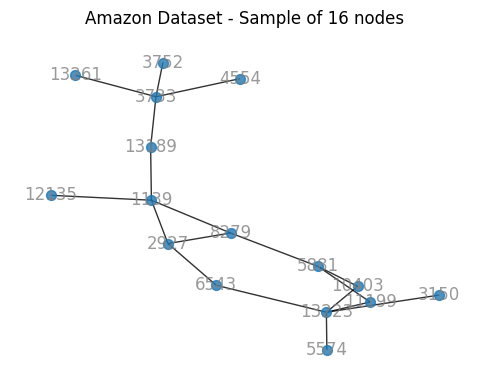

In [10]:
visualize_subgraph_largest_cc(data, num_nodes=200)

## 2. Train a GNN yourself

Now we have the dataset, let's train a GNN on it!

We will first try Graph Convolutional Networks (GCNs). Similar to PyTorch, PyG provides common GNN layers out-of-the-box.

First of all, we have to split the dataset into train and test sets.

In the graph context, we split a portion of the nodes for training, validation, and testing.

In [11]:
from torch_geometric.transforms import RandomNodeSplit

# The RandomNodeSplit transform is used to split the dataset into train, validation, and test sets.
node_transform = RandomNodeSplit(
    num_val=0.1,
    num_test=0.2,
)
# Apply the transform to the dataset
splitted_data = node_transform(data)

You will now see that, the splitted data has masks for train, validation, and test sets.

In [12]:
print(f"Number of training nodes: {splitted_data.train_mask.sum()}")
print(f"Number of validation nodes: {splitted_data.val_mask.sum()}")
print(f"Number of test nodes: {splitted_data.test_mask.sum()}")

Number of training nodes: 9627
Number of validation nodes: 1375
Number of test nodes: 2750


Let's go! We can first define a simple GCN that has two convolutional layers.

In [13]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

`GCNConv` is a torch module that implements the graph convolutional layer.

You can have a look at its input and outputs.

In [14]:
example_conv = GCNConv(
    in_channels=dataset.num_node_features,
    out_channels=dataset.num_classes,
)

print(f"Input shape: {data.x.shape}")
print(f"Input edge index shape: {data.edge_index.shape}")
# Forward pass
out = example_conv(data.x, data.edge_index)
print(f"Output shape: {out.shape}")
print(f"Output edge index shape: {data.edge_index.shape}")

Input shape: torch.Size([13752, 767])
Input edge index shape: torch.Size([2, 491722])
Output shape: torch.Size([13752, 10])
Output edge index shape: torch.Size([2, 491722])


The number of input features can be acquired from the dataset.

For the hidden channels, we pick a 256-dimensional hidden layer
(in reality, you should do experimentation to find the best hyperparameters instead of randomly picking one).

In [13]:
gcn_model = GCN(
    in_channels=dataset.num_node_features,
    out_channels=dataset.num_classes,
    hidden_channels=256,
)

print(gcn_model)

GCN(
  (conv1): GCNConv(767, 256)
  (conv2): GCNConv(256, 10)
)


Let's now write the training loop.

It is very similar to the PyTorch ones you have seen in previous notebooks.

In [14]:
gcn_optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.01, weight_decay=5e-4)
gcn_criterion = torch.nn.CrossEntropyLoss()


def train_gcn(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()  # Clear gradients
    out = model(data.x, data.edge_index)  # Forward pass
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute loss
    loss.backward()  # Backward pass
    optimizer.step()  # Update weights
    return loss.item()


def test_gcn(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)  # Get the predicted class
        test_acc = (
            pred[data.test_mask] == data.y[data.test_mask]
        ).sum().item() / data.test_mask.sum().item()
        val_acc = (
            pred[data.val_mask] == data.y[data.val_mask]
        ).sum().item() / data.val_mask.sum().item()
    return test_acc, val_acc

In [15]:
# Run the training loop
num_epochs = 100

# Migrate to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
gcn_model = gcn_model.to(device)
splitted_data = splitted_data.to(device)

# Prepare logs
gcn_train_logs = []
gcn_val_logs = []
gcn_test_logs = []

for epoch in range(num_epochs):
    loss = train_gcn(gcn_model, splitted_data, gcn_optimizer, gcn_criterion)
    test_acc, val_acc = test_gcn(gcn_model, splitted_data)
    gcn_train_logs.append(loss)
    gcn_val_logs.append(val_acc)
    gcn_test_logs.append(test_acc)

    if epoch % 10 == 0:
        print(
            f"Epoch {epoch}: Loss: {loss:.4f}, Validation Accuracy: {val_acc:.4f}, Test Accuracy: {test_acc:.4f}"
        )

Using device: cpu
Epoch 0: Loss: 2.4119, Validation Accuracy: 0.3927, Test Accuracy: 0.3756
Epoch 10: Loss: 2.2264, Validation Accuracy: 0.1447, Test Accuracy: 0.1549
Epoch 20: Loss: 1.5540, Validation Accuracy: 0.6291, Test Accuracy: 0.6218
Epoch 30: Loss: 1.0748, Validation Accuracy: 0.7251, Test Accuracy: 0.7324
Epoch 40: Loss: 0.7553, Validation Accuracy: 0.8211, Test Accuracy: 0.7978
Epoch 50: Loss: 0.5945, Validation Accuracy: 0.8553, Test Accuracy: 0.8440
Epoch 60: Loss: 0.5325, Validation Accuracy: 0.8691, Test Accuracy: 0.8604
Epoch 70: Loss: 0.4739, Validation Accuracy: 0.8749, Test Accuracy: 0.8705
Epoch 80: Loss: 0.4304, Validation Accuracy: 0.8851, Test Accuracy: 0.8749
Epoch 90: Loss: 0.4026, Validation Accuracy: 0.8807, Test Accuracy: 0.8742


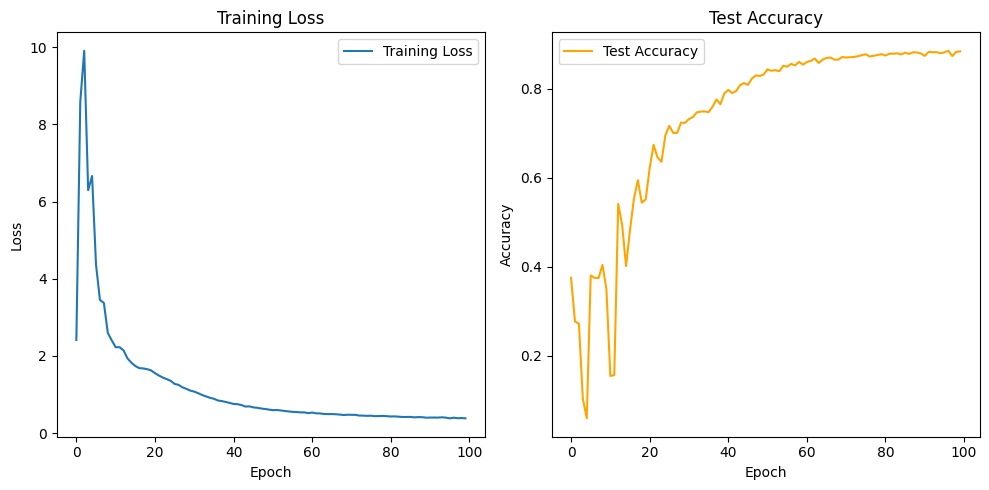

In [16]:
# Plot the training loss and test accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(gcn_train_logs, label="Training Loss")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(gcn_test_logs, label="Test Accuracy", color="orange")
plt.title("Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

> 📚 **EXERCISE**
>
> Another model you can try is the Graph Attention Network (GAT). GAT learns attention weights for each node's neighbors, allowing it to focus on more important connections and potentially ignore noisy or irrelevant ones. (Recall the previous Transformer notebook about the attention mechanism.)
>
> Similar to GCN, it is also implemented in PyG:
> ```python
> # If you want a GAT right out of the box:
> from torch_geometric.nn import GAT
> gat = GAT(in_channels: int, hidden_channels: int, num_layers: int, out_channels: Optional[int] = None, dropout: float = 0.0)
> # Or, if you want to use the GATConv layer like you build a CNN from scratch:
> from torch_geometric.nn import GATConv
> ...
> self.conv1 = GATConv(in_channels, hidden_channels, heads=<number of heads>)
> ```
>
> Mimic the previous GCN code and implement a GAT model. Compare the results with GCN.

In [17]:
# === Your code here ===

## 3. Oversmoothing

Oversmoothing is a phenomenon that occurs in GNNs when the node representations become indistinguishable after several layers of message passing.

Hence, deeper GNNs may not perform well in downstream tasks, and this phenomenon effectively limits the depth of network.

Let's take a look at why. We can initialize a deeper CNN and see what happens with the features as it passes through the layers.

In [19]:
# PyG actually has a built-in GCN model, we will use that in this demonstration
import torch_geometric.nn as pyg_nn

vanilla_gcn = pyg_nn.GCN(
    in_channels=dataset.num_node_features,
    out_channels=dataset.num_classes,
    hidden_channels=256,
    num_layers=10,
    dropout=0.5,
)
print(vanilla_gcn)

GCN(767, 10, num_layers=10)


In [21]:
print("===GCN Conv layers===")
print(vanilla_gcn.convs)

===GCN Conv layers===
ModuleList(
  (0): GCNConv(767, 256)
  (1-8): 8 x GCNConv(256, 256)
  (9): GCNConv(256, 10)
)


In [25]:
# We can register a hook for recording the output of each layer
def get_layer_outputs(model, data):
    layer_outputs = []

    def hook(module, input, output):
        layer_outputs.append(output)

    hooks = []
    for layer in model.convs:
        hooks.append(layer.register_forward_hook(hook))

    # Forward pass
    model.eval()
    with torch.no_grad():
        model(data.x, data.edge_index)

    # Remove hooks
    for hook in hooks:
        hook.remove()

    return layer_outputs

In [23]:
vanilla_gcn_outputs = get_layer_outputs(vanilla_gcn, splitted_data)

In [30]:
def get_average_variance(layer_outputs):
    """
    Calculate the average variance of the outputs of each layer.

    Args:
        layer_outputs: List of layer outputs
    """
    avg_variances = []
    for i in range(len(layer_outputs)):
        var = torch.var(layer_outputs[i], dim=0)
        avg_variances.append(var.mean().item())
    return avg_variances

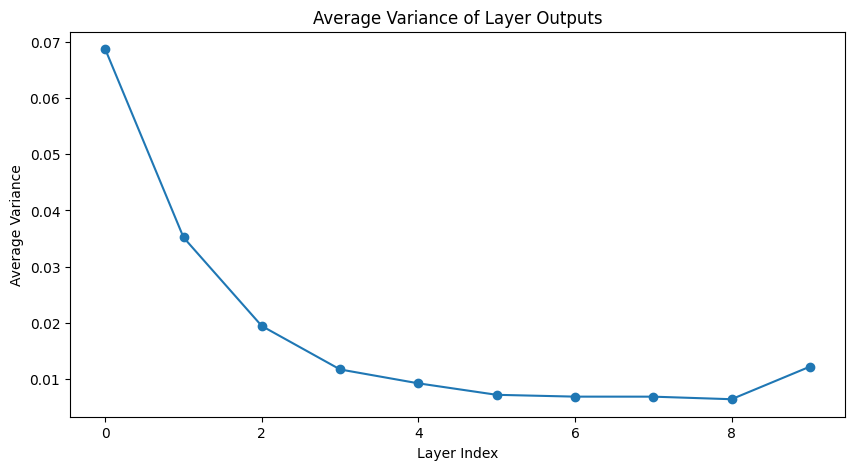

In [34]:
variances = get_average_variance(vanilla_gcn_outputs)

plt.figure(figsize=(10, 5))
plt.plot(variances, marker="o")
plt.title("Average Variance of Layer Outputs")
plt.xlabel("Layer Index")
plt.ylabel("Average Variance")
plt.show()

As you can see, the variance of the features decreases as the number of layers increases, suggesting that the features are becoming more similar to each other.

> 🤔 **THINKING**
>
> There exist some approaches to mitigate oversmoothing. As an example, below is an excerpt of implementation in PyG of `DeepGCNLayer`, 
> enabling the training of much deeper GCNs.
>
> Read the code, and answer the following questions:
> - What do you think the scientists are trying to do?
> - Did this remind you of some models we have learnt before?
> - (Optional) Implement a model with this methodology and compare it to a vanilla GCN. Did you observe any difference?

```python
# torch_geometric/nn/models/deepgcn.py
class DeepGCNLayer(torch.nn.Module):
    def __init__(
        self,
        conv: Optional[Module] = None,
        norm: Optional[Module] = None,
        act: Optional[Module] = None,
        block: str = 'res+',
        dropout: float = 0.,
        ckpt_grad: bool = False,
    ):
    # ...

    # ...
    def forward(self, *args, **kwargs) -> Tensor:
        # ...
        if self.block == 'res+':
            h = x
            if self.norm is not None:
                h = self.norm(h)
            if self.act is not None:
                h = self.act(h)
            h = F.dropout(h, p=self.dropout, training=self.training)
            if self.conv is not None and self.ckpt_grad and h.requires_grad:
                h = checkpoint(self.conv, h, *args, use_reentrant=True,
                               **kwargs)
            else:
                h = self.conv(h, *args, **kwargs)

            return x + h
        # ...
```